In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models, optimizers
from keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report

In [2]:
def show_result(test1):
    # Mostrar los resultados
    fig, ax = plt.subplots(2,1,figsize=(6,3))
    ax[0].plot(test1.history['loss'], color='b', label="Training loss")
    ax[0].plot(test1.history['val_loss'], color='r', label="validation loss")
    legend = ax[0].legend(loc='best', shadow=True)
    ax[0].grid()

    ax[1].plot(test1.history['accuracy'], color='b', label="Training accuracy")
    ax[1].plot(test1.history['val_accuracy'], color='r',label="Validation accuracy")
    ax[1].set_ylim(0,1)
    legend = ax[1].legend(loc='best', shadow=True)
    ax[1].grid()

    plt.tight_layout()
    plt.show()

In [3]:
# Cargar los datasets
feat_train = np.load('../0_training_datasets/feat_train_v2.npy')
label_train = np.load('../0_training_datasets/label_train_v2.npy')
feat_val = np.load('../0_training_datasets/feat_val_v2.npy')
label_val = np.load('../0_training_datasets/label_val_v2.npy')


In [5]:
## Estructura 
### ResNet50

inputshape=(128, 141, 1)

def resnet_block(x, filters, kernel_size=3, stride=1, use_shortcut=True):
    shortcut = x
    if stride != 1 or x.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same', use_bias=False)(x)
        shortcut = layers.BatchNormalization()(shortcut)
    
    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(filters, kernel_size=kernel_size, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    
    return x

def ResNet50(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    
    # Capa inicial
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    
    # Primer grupo de bloques residuales
    x = resnet_block(x, 64)
    x = resnet_block(x, 64)
    x = resnet_block(x, 64)
    
    # Segundo grupo de bloques residuales
    x = resnet_block(x, 128, stride=2)
    x = resnet_block(x, 128)
    x = resnet_block(x, 128)
    
    # Tercer grupo de bloques residuales
    x = resnet_block(x, 256, stride=2)
    x = resnet_block(x, 256)
    x = resnet_block(x, 256)
    x = resnet_block(x, 256)
    
    # Cuarto grupo de bloques residuales
    x = resnet_block(x, 512, stride=2)
    x = resnet_block(x, 512)
    
    # Capa Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)
    
    # Capa densa de salida
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    # Crear el modelo
    model = models.Model(inputs=inputs, outputs=outputs,name="ResNet-50")
    
    return model

# Crear el modelo ResNet50
model_ResNet50 = ResNet50(input_shape=inputshape,num_classes=4)

# Resumen del modelo
model_ResNet50.summary()

Model: "ResNet-50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 141,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 71,    │      3,136 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 71,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 64, 71,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 36,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 36,    │     36,864 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 36,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 32, 36,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 36,    │     36,864 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 36,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 36,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 32, 36,    │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 36,    │     36,864 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 36,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 32, 36,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 36,    │     36,864 │ re_lu_3[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 36,    │        256 │ conv2d_4[0][0]  

 Total params: 13,915,460 (53.08 MB)

 Trainable params: 13,903,044 (53.04 MB)

 Non-trainable params: 12,416 (48.50 KB)

In [6]:
# Define el optimizador y compila el modelo
optimizer = optimizers.Adam(learning_rate=0.0001)
model_ResNet50.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [7]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [8]:
# Entrena el modelo
history = model_ResNet50.fit(feat_train, label_train,
                   batch_size=32, epochs=50,
                   validation_data=(feat_val, label_val),
                   verbose=1,
                   callbacks=[early_stopping]
                   )

test_loss, test_acc = model_ResNet50.evaluate(feat_val, label_val, verbose=2)


Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 23s 599ms/step - accuracy: 0.5456 - loss: 1.1560 - val_accuracy: 0.2500 - val_loss: 2.8151
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 566ms/step - accuracy: 0.8670 - loss: 0.3624 - val_accuracy: 0.2895 - val_loss: 1.6068
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 533ms/step - accuracy: 0.9632 - loss: 0.1099 - val_accuracy: 0.3947 - val_loss: 1.2799
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 538ms/step - accuracy: 0.9922 - loss: 0.0442 - val_accuracy: 0.6053 - val_loss: 1.2092
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 554ms/step - accuracy: 0.9966 - loss: 0.0236 - val_accuracy: 0.6053 - val_loss: 1.3285
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 556ms/step - accuracy: 0.9846 - loss: 0.0396 - val_accuracy: 0.6316 - val_loss: 1.5242
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 573ms/step - accuracy: 0.9797 - loss: 0.0514 - val_accuracy: 0.6184 - val_loss: 1.3081
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 543ms/step - accuracy: 0.9682 - loss: 0.0862 - val_accu

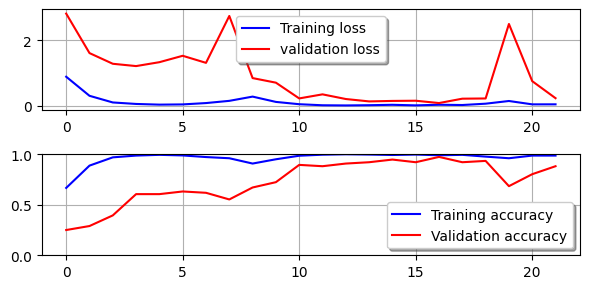

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 337ms/step
              precision    recall  f1-score   support

     Paisaje       1.00      0.95      0.97        20
       Avion       0.95      1.00      0.97        19
       Motor       1.00      0.95      0.98        21
       Voces       0.94      1.00      0.97        16

    accuracy                           0.97        76
   macro avg       0.97      0.98      0.97        76
weighted avg       0.98      0.97      0.97        76



In [9]:
show_result(history)
# Haz predicciones en el conjunto de validación
y_pred = model_ResNet50.predict(feat_val)

# Convierte las predicciones a etiquetas de clase
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(label_val, axis=1)

# Calcula precision, recall, y F1-score
report = classification_report(y_true_classes, y_pred_classes, target_names=['Paisaje', 'Avion', 'Motor', 'Voces'])
print(report)

In [10]:
model_ResNet50.save("ResNet50_v2.keras")